# benchmarking on sergio


In [1]:
from bengrn import BenGRN
import scanpy as sc

from scdataloader import Preprocessor

from anndata.utils import make_index_unique

from grnndata import utils as grnutils
from grnndata import read_h5ad
import numpy as np
import pandas as pd

from scdataloader import utils as data_utils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
adata = read_h5ad("../tools/SERGIO/sergio_gt_grn.h5ad")
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genesdf = data_utils.load_genes(adata.obs.organism_ontology_term_id.iloc[0])
adata

GRnnData object with n_obs × n_vars = 1000 × 813
    obs: 'organism_ontology_term_id'
    varp: 'GRN'
    with a grn of 3546 elements

In [5]:
# Merge adata.var with genesdf
# First, ensure the index of adata.var is named
adata.var.index.name = 'symbol'

# Merge adata.var with genesdf
# Merge adata.var with genesdf, keeping only the first instance of each symbol
merged_var = adata.var.reset_index().merge(
    genesdf.reset_index().drop_duplicates(subset='symbol', keep='first'),
    left_on='symbol',
    right_on='symbol',
    how='left'
)

# Set the index back to 'symbol'
merged_var.set_index('symbol', inplace=True)
adata.var = merged_var
adata.var['symbol'] =  adata.var.index

In [6]:
subadata = adata[:, adata.var.ensembl_gene_id.isin(genes)].copy()
del subadata.varp['GRN']

In [11]:
subadata.var['symbol'] = subadata.var.index
subadata.var.index = subadata.var.ensembl_gene_id

In [13]:
subadata.var.drop(columns=['mt', 'ribo', 'hb'], inplace=True)

In [14]:
# normal
genie_grn = compute_geneformer_network(subadata)

/tmp/ipykernel_2490168/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [17]:
genie_grn.var.index = genie_grn.var.symbol

precision:  0.035131685266942256 
recall:  0.9036144578313253 
random precision: 0.032081014223871364


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2902.15it/s]

Average Precision (AP):  0.059903753435359065
Area Under Precision-Recall Curve (AUPRC):  0.059444333596468585
EPR: 3.775053474390103


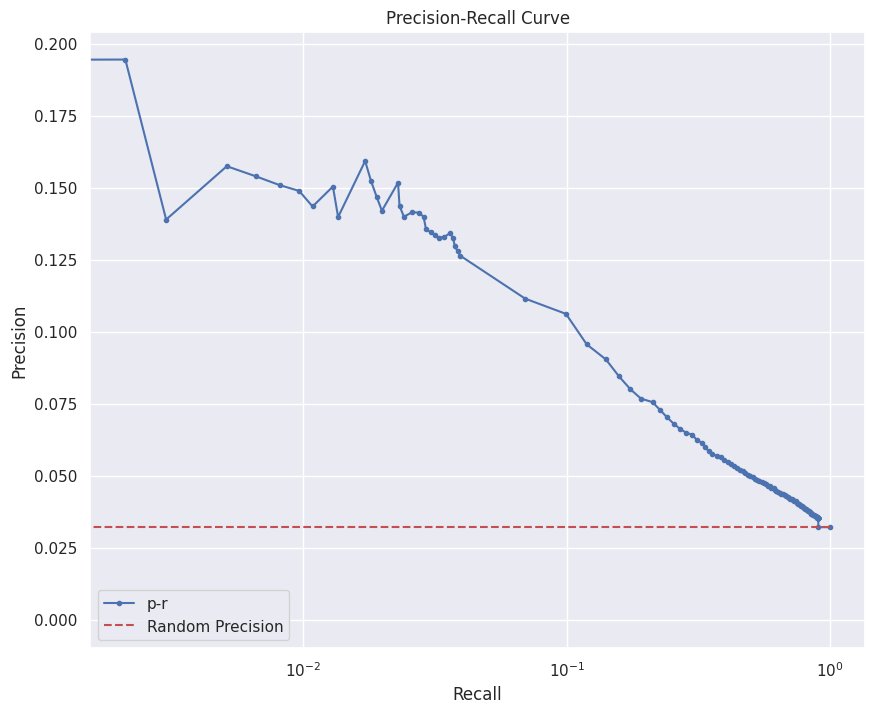

{'precision': 0.035131685266942256,
 'recall': 0.9036144578313253,
 'rand_precision': 0.032081014223871364,
 'auprc': 0.059444333596468585,
 'ap': 0.059903753435359065,
 'epr': 3.775053474390103}

In [18]:
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


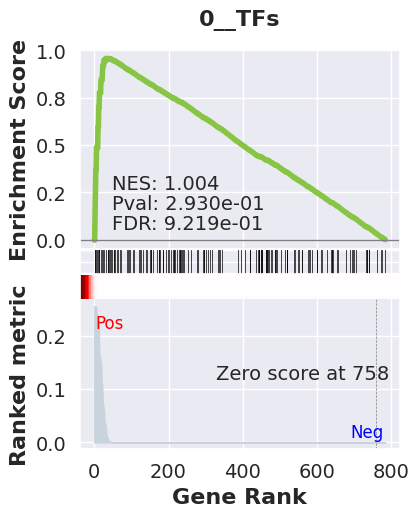

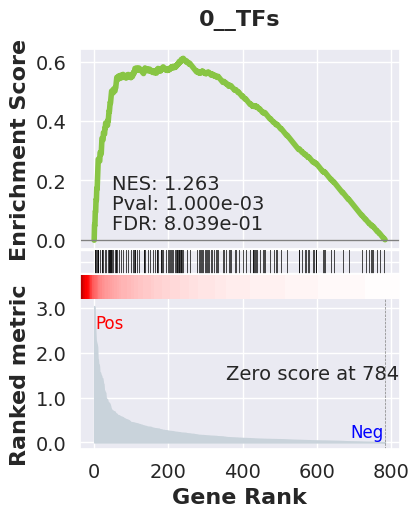

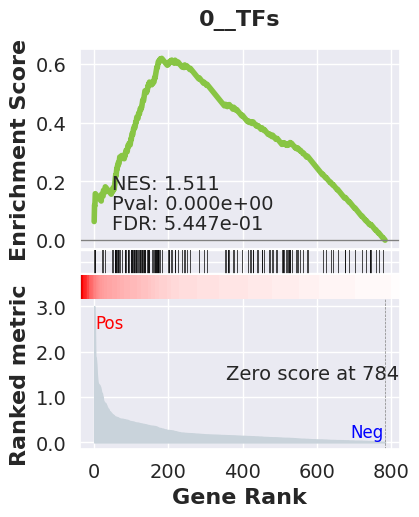

_________________________________________
TF specific enrichment
found some significant results for  26.31578947368421 % TFs

_________________________________________
loading GT,  omnipath
intersection of 642 genes
intersection pct: 0.8178343949044586
precision:  0.028568740185072224 
recall:  0.8612089201877934 
random precision: 0.02484435826031172


 89%|████████▉ | 114/128 [00:00<00:00, 564.78it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 561.02it/s]


Average Precision (AP):  0.04658536827037337
Area Under Precision-Recall Curve (AUPRC):  0.04614212663445056
EPR: 3.6912476496101614


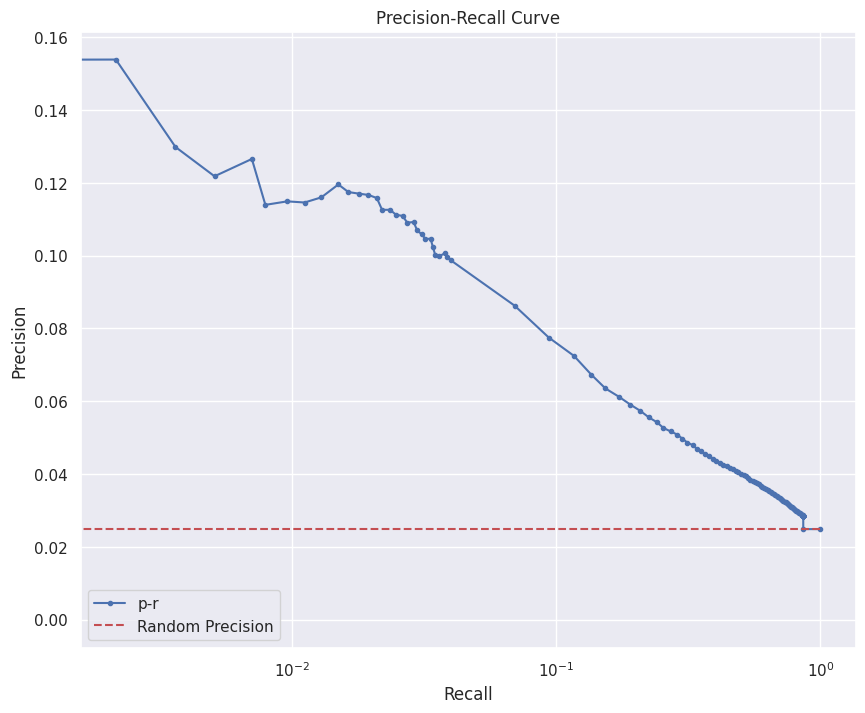

{'enriched_terms_Central': ['celltype.gmt__Neutrophils',
  'celltype.gmt__Granulocytes'],
 'TF_enr': False,
 'significant_enriched_TFtargets': 26.31578947368421,
 'precision': 0.028568740185072224,
 'recall': 0.8612089201877934,
 'rand_precision': 0.02484435826031172,
 'auprc': 0.04614212663445056,
 'ap': 0.04658536827037337,
 'epr': 3.6912476496101614}

In [19]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
BenGRN(genie_grn).scprint_benchmark()